<a href="https://colab.research.google.com/github/Poorvahi/QuizProject/blob/main/K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
file_path = "/content/Online_Retail_Cleaned.xlsx"
df = pd.read_excel(file_path)
print(df.head())

   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# quick checks
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df.shape)
print(df[['InvoiceNo','CustomerID','Quantity','UnitPrice']].head())

(392692, 9)
   InvoiceNo  CustomerID  Quantity  UnitPrice
0     536365       17850         6       2.55
1     536365       17850         6       3.39
2     536365       17850         8       2.75
3     536365       17850         6       3.39
4     536365       17850         6       3.39


In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [ ]:
rfm = df.groupby('CustomerID').agg({
    # Recency
    'InvoiceDate': lambda x: (reference_date - x.max()).days,

    # Frequency
    'InvoiceNo': 'nunique',

    # Monetary
    'TotalPrice': 'sum',

    # TotalQuantity
    'Quantity': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'TotalQuantity']

# Basketing
rfm['Avg_Basket_Size'] = rfm['TotalQuantity'] / rfm['Frequency']            # items per invoice
rfm['Avg_Item_Price'] = rfm['Monetary'] / rfm['TotalQuantity']              # spend per item

# Fix divide-by-zero or infinite values
rfm['Avg_Basket_Size'].replace([np.inf, -np.inf], 0)
rfm['Avg_Item_Price'].replace([np.inf, -np.inf], 0)

# Preview
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary  TotalQuantity  Avg_Basket_Size  \
0       12346      326          1  77183.60          74215     74215.000000   
1       12347        2          7   4310.00           2458       351.142857   
2       12348       75          4   1797.24           2341       585.250000   
3       12349       19          1   1757.55            631       631.000000   
4       12350      310          1    334.40            197       197.000000   

   Avg_Item_Price  
0        1.040000  
1        1.753458  
2        0.767723  
3        2.785341  
4        1.697462  


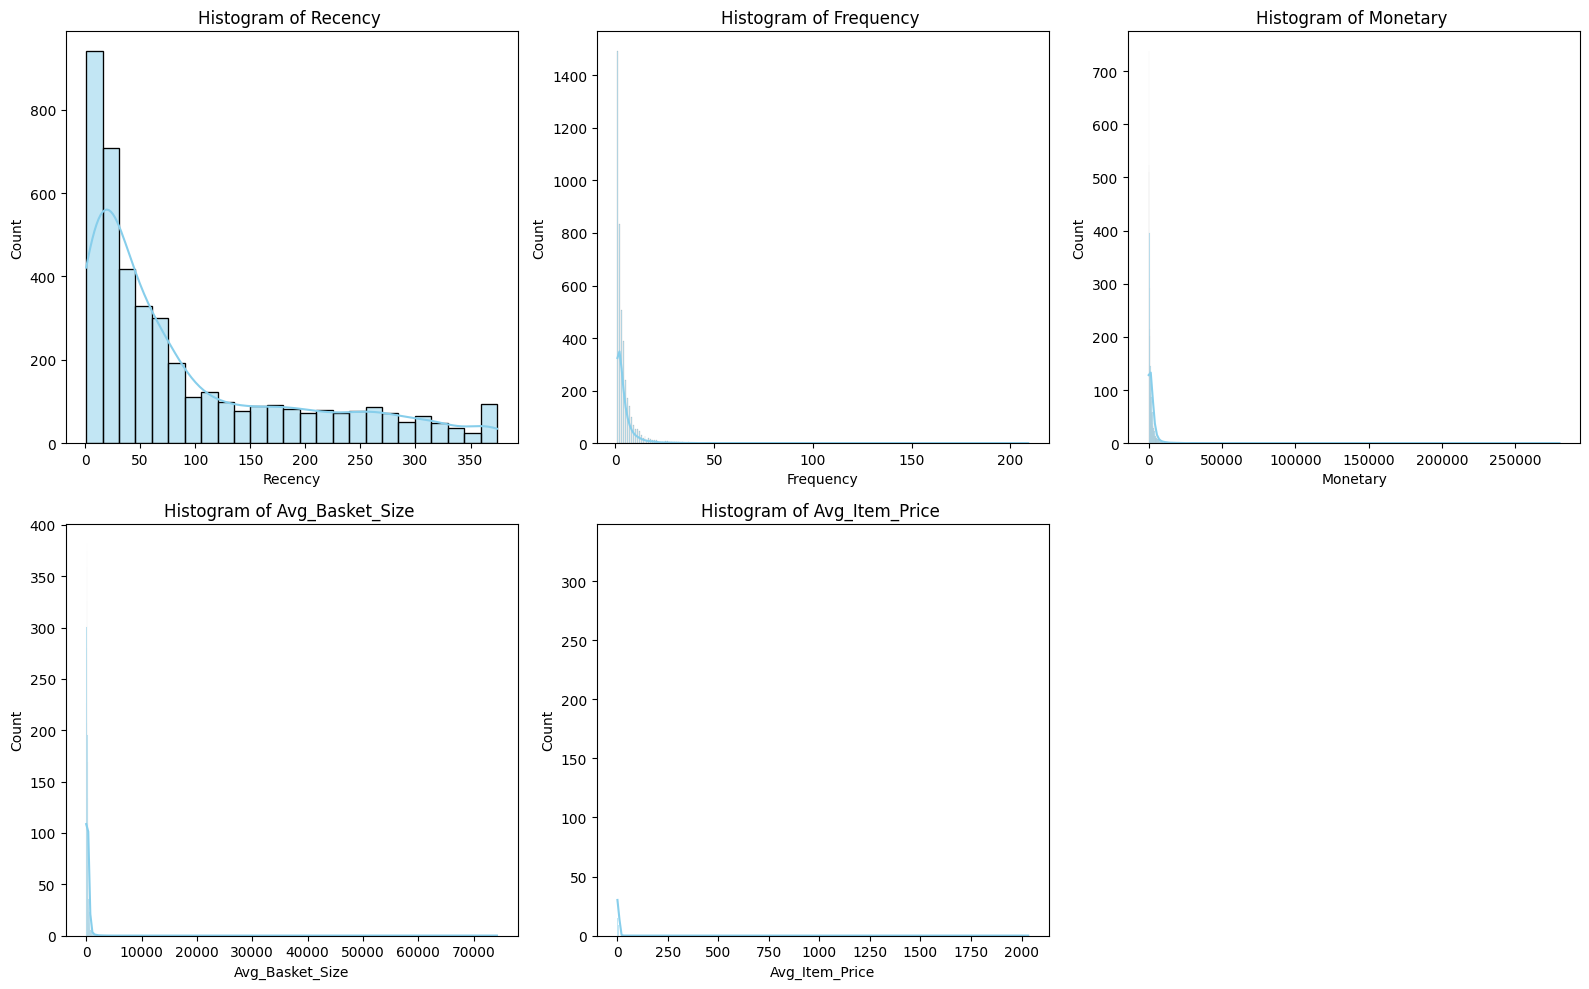

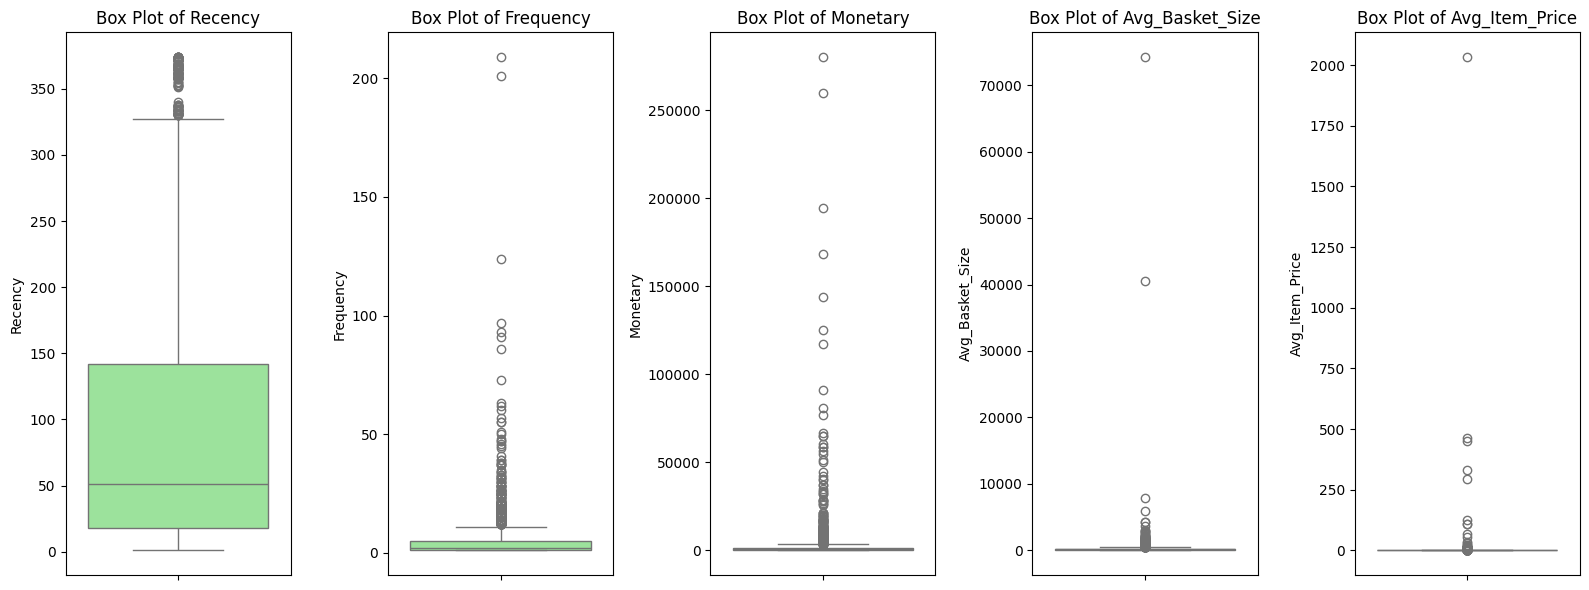

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Recency', 'Frequency', 'Monetary', 'Avg_Basket_Size', 'Avg_Item_Price']

# 1. Histograms
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(rfm[feature], kde=True, color='skyblue')
    plt.title(f'Histogram of {feature} ')
plt.tight_layout()
plt.show()

# 2. Box plots
plt.figure(figsize=(16, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(y=rfm[feature], color='lightgreen')
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_to_scale = ['Recency', 'Frequency', 'Monetary', 'Avg_Basket_Size', 'Avg_Item_Price']
rfm_scaled = scaler.fit_transform(rfm[features_to_scale])

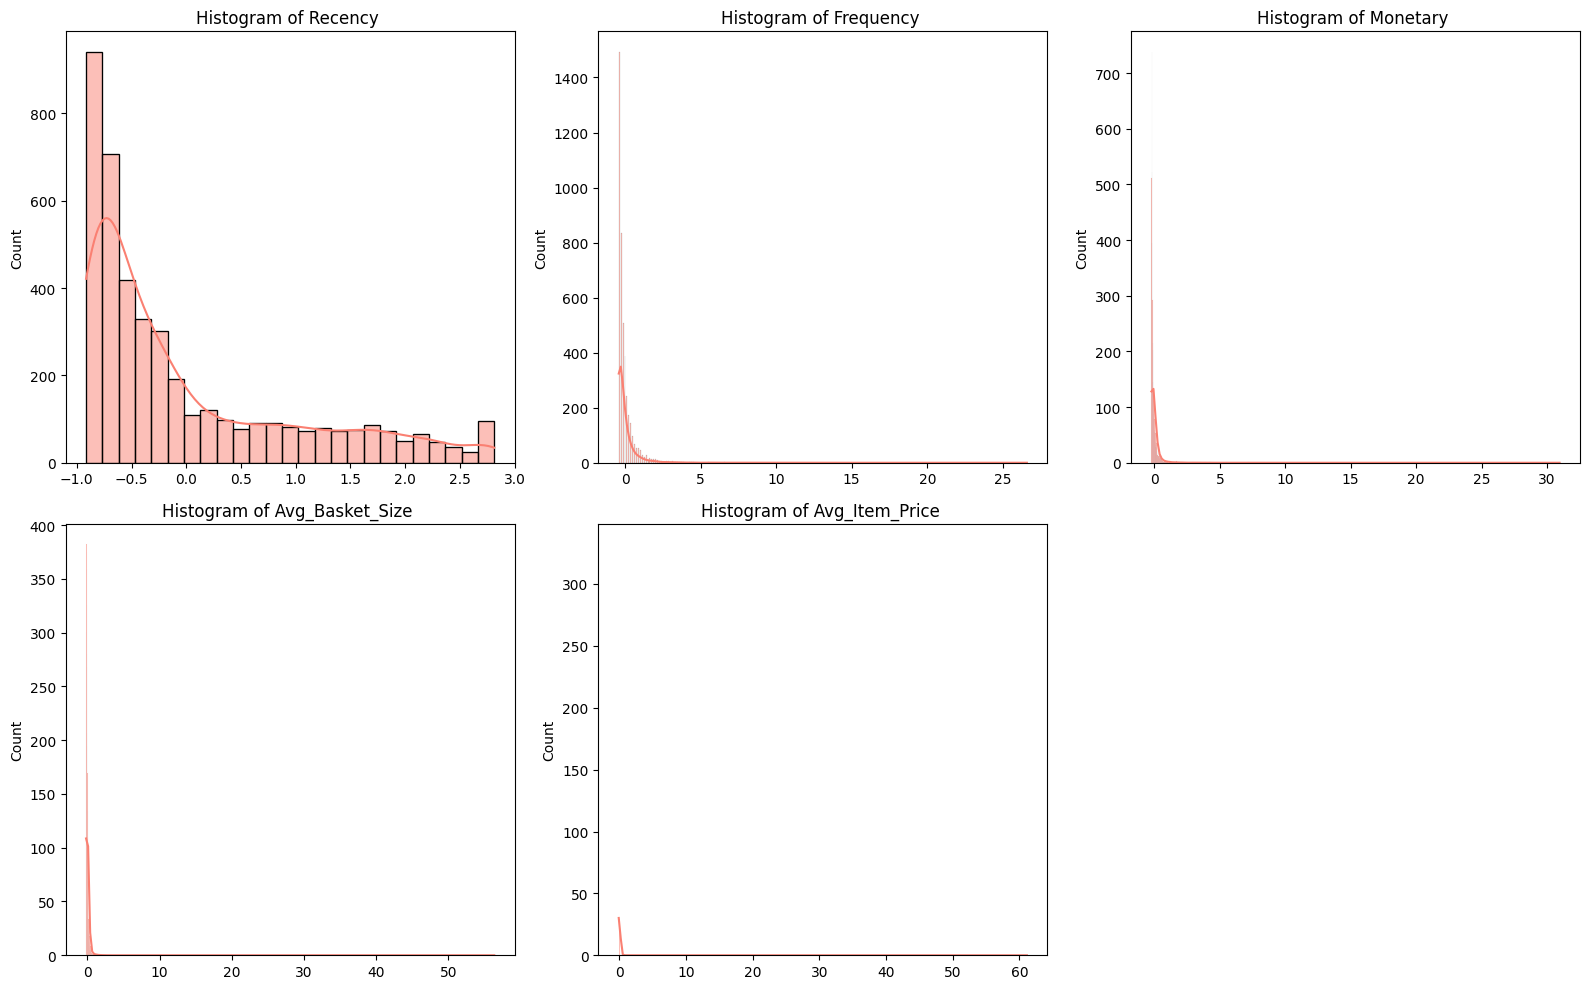

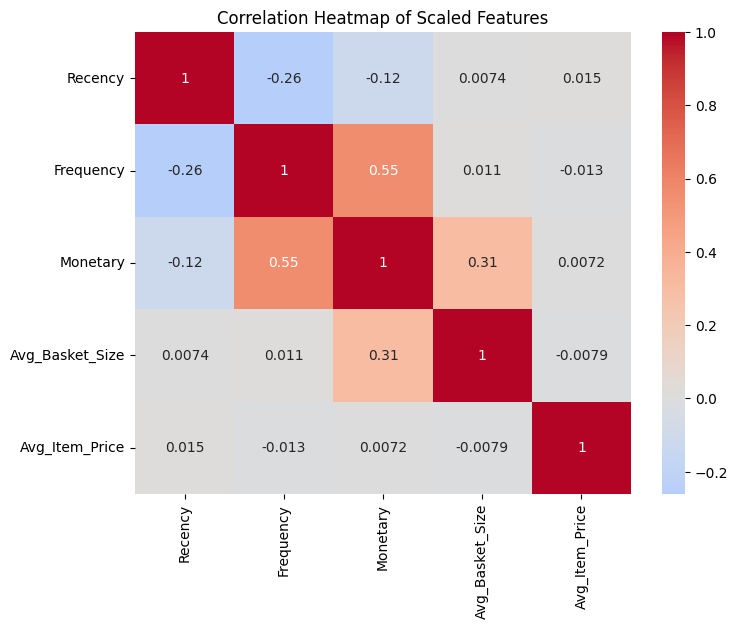

In [ ]:
# 3. Histograms
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(rfm_scaled[:, i-1], kde=True, color='salmon')
    plt.title(f'Histogram of {feature} ')
plt.tight_layout()
plt.show()

# 4. Heatmap of correlations
import pandas as pd
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=features)
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_scaled_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Scaled Features')
plt.show()

In [ ]:
zero_count = (rfm['Monetary'] == 0).sum()
print("Number of zeros:",zero_count)

Number of zeros: 0


In [ ]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Cluster labels for each customer
cluster_labels = kmeans.labels_


In [ ]:
rfm['Cluster'] = cluster_labels


In [ ]:
cluster_profile = rfm.groupby('Cluster').mean()
print(cluster_profile)


           CustomerID     Recency  Frequency       Monetary  TotalQuantity  \
Cluster                                                                      
0        15281.364087   40.970279   4.853870    2005.821989    1193.107430   
1        17846.000000   85.000000   1.000000    2033.100000       1.000000   
2        15356.980769  245.950549   1.583333     559.252821     285.161172   
3        15113.000000   28.400000  74.933333  119711.112667   65791.200000   

         Avg_Basket_Size  Avg_Item_Price  
Cluster                                   
0             237.162787        2.150718  
1               1.000000     2033.100000  
2             182.218945        3.724193  
3            8677.609212        1.854918  


In [ ]:
print(rfm['Cluster'].value_counts())


Cluster
0    3230
2    1092
3      15
1       1
Name: count, dtype: int64


In [ ]:
cluster_names = {
    0: 'Loyal Customers',
    1: 'At Risk',
    2: 'Best Customers',
    3: 'Lost Customers'
}

rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)

# Preview
print(rfm[['CustomerID', 'Cluster', 'Cluster_Name']].head())

   CustomerID  Cluster     Cluster_Name
0       12346        3   Lost Customers
1       12347        0  Loyal Customers
2       12348        0  Loyal Customers
3       12349        0  Loyal Customers
4       12350        2   Best Customers


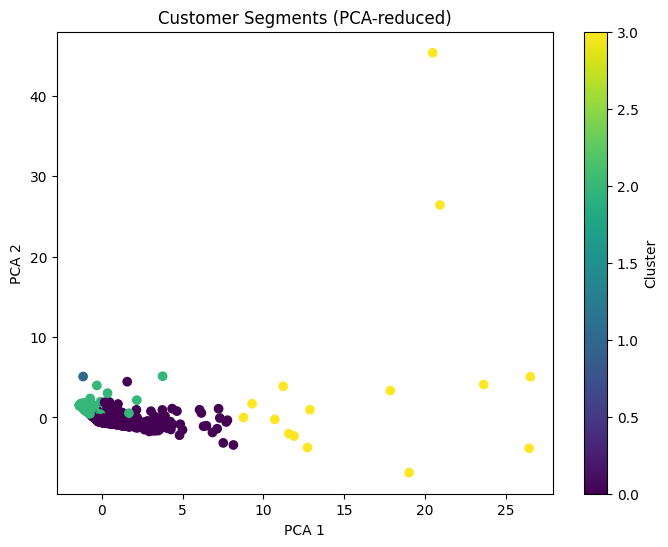

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Customer Segments (PCA-reduced)')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Save final RFM dataset with clusters to Excel
output_path = "/content/rfm_clusters.xlsx"
rfm.to_excel(output_path, index=False)

print(f"File saved to: {output_path}")


File saved to: /content/rfm_clusters.xlsx


In [ ]:
from google.colab import files
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>